In [1]:
year = "2017"

In [2]:
import sys, os
import ROOT as R

Welcome to JupyROOT 6.16/00


In [6]:
%env ANALYSISHOME=/home/mo/Analysis/HMuMu

env: ANALYSISHOME=/home/mo/Analysis/HMuMu


In [7]:
sys.path.append(os.path.join(os.environ["ANALYSISHOME"], "Configuration", "higgs"))                     
 

In [8]:
import Samples as S

In [10]:
datafile = "../histoFiles/{}/allData{}.root".format(year,year)
mc2016 = S.mc_background_2016
mc2016.update(S.mc_signal_2016)

mc2017 = S.mc_background_2017
mc2017.update(S.mc_signal_2017)

mc2018 = S.mc_background_2018
mc2018.update(S.mc_signal_2018)

mc_datasets_dic = {
    "2016": mc2016,
    "2017": mc2017,
    "2018": mc2018
}
jsonfiles = S.jsonfiles
jsonfile = jsonfiles[year]

In [11]:
dataFile = R.TFile.Open(datafile)

In [12]:
lumi = jsonfile.intlumi

In [13]:
mc_samples = mc_datasets_dic[year]

In [14]:
root_dic = []
for file in os.listdir("../histoFiles/{}/".format(year)):
    if file.endswith(".root") and not file.startswith("all"):
        nickname = file.replace(".root","")
        dic = {}
        dic["fullname"] = file
        for k,v in mc_samples.items():
            if nickname in k:
                dic["isSignal"] = v.isSignal                    
        f = R.TFile.Open("../histoFiles/{}/".format(year)+file)
        dic["file"] = f
        root_dic.append((nickname,dic))

In [12]:
# if M125 + isSignal we plot as a signal line
# if not isSignal then add to background
# plotting might kill memory? lol..

In [16]:
bcColors = [40,30,41,42,43,35,46,47,38,28,29]
sigColors = [2,3,4,6,8,9]

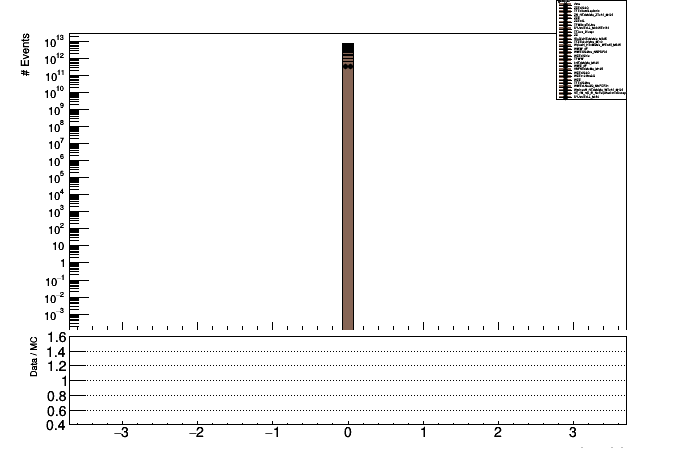

In [14]:
variable = "dimuon_phi"

logy = True
canvas = R.TCanvas("c1","c1")
canvas.cd()
pad1 = R.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0)
pad1.Draw()
canvas.cd()
pad2 = R.TPad("pad2", "pad2", 0, 0.05, 1, 0.3)
pad2.Draw()
pad2.cd()
pad2.SetTopMargin(0.05)
pad2.SetBottomMargin(0.2)
pad2.SetGridy()
pad1.cd()

bkgStack = R.THStack("bkgStack","")
sigStack = R.THStack("sigStack","")
allStack = R.THStack("allStack","")

hdata = dataFile.Get(variable)

leg = R.TLegend(0.8, 0.7, .9, 1.)
leg.SetHeader("Samples")
leg.AddEntry(hdata, "data")

sigHistos = []
i = 0
j = 0
for v in root_dic:
    # background
    
    if not v[1]["isSignal"]:
        rnt = v[1]["file"].Get("ntupledData")
        rnt.Draw("{}*totalWeight>>tempHisto".format(variable))
        histo = R.gDirectory.Get("tempHisto")
        histo.SetLineWidth(1)
        histo.SetLineColor(R.kBlack)
#         histo.SetTitle(v[0])
        histo.SetFillColor(bcColors[(i%len(bcColors))])
        # multiply by lumi!
        histo.Scale(lumi)
        leg.AddEntry(histo,v[0])
        bkgStack.Add(histo)
        allStack.Add(histo)
#       bgsum.Add(histo)
        i+=1
    # signal, only draw 125 GeV
    if v[1]["isSignal"] and "M125" in v[1]["fullname"]:
        rnt = v[1]["file"].Get("ntupledData")
        rnt.Draw("{}*totalWeight>>tempHisto".format(variable))
        histo = R.gDirectory.Get("tempHisto")
        histo.SetLineColor(sigColors[(j%len(sigColors))])
        histo.Scale(lumi)
        leg.AddEntry(histo,v[0])
        sigHistos.append(histo)
        sigStack.Add(histo)
        allStack.Add(histo)
        j+=1

if variable == "dimuon_mass":
    for i in range(hdata.GetNbinsX()):
        if hdata.GetBinCenter(i+1)>120 and hdata.GetBinCenter(i+1)<130:
            hdata.SetBinContent(i+1, 0)

hdata.SetMarkerStyle(20)
hdata.SetMarkerSize(.5)
if logy:
    pad1.SetLogy()
    bkgStack.SetMinimum(.001)

hdata.SetStats(R.kFALSE)
hdata.GetXaxis().SetLabelSize(0)
bkgStack.Draw("hist")
for h in sigHistos:
    h.Draw("hist same")
hdata.Draw("same p")
bkgStack.GetXaxis().SetTitle(variable)
bkgStack.GetYaxis().SetTitle("# Events")
leg.Draw()
R.gPad.Modified()


pad2.cd()
hratio = hdata.Clone()
hratio.SetTitle("")
hratio.GetYaxis().SetTitle("Data / MC")
hratio.GetXaxis().SetTitle(variable)
hratio.GetYaxis().SetNdivisions(6, R.kFALSE)
hratio.GetYaxis().SetTitleSize(10)
hratio.GetYaxis().SetTitleFont(43)
hratio.GetYaxis().SetTitleOffset(1.55)
hratio.GetYaxis().SetLabelFont(43)
hratio.GetYaxis().SetLabelSize(15)
hratio.GetXaxis().SetTitleSize(20)
hratio.GetXaxis().SetTitleFont(43)
hratio.GetXaxis().SetTitleOffset(4)
hratio.GetXaxis().SetLabelFont(43)
hratio.GetXaxis().SetLabelSize(15)
hratio.Divide(allStack.GetStack().Last())
hratio.SetStats(R.kFALSE)
hratio.Draw("ep")
hratio.SetMaximum(1.6)
hratio.SetMinimum(0.4)
hratio.SetMarkerStyle(20)
hratio.SetMarkerSize(0.5)
R.gPad.Modified()
canvas.Draw()
